## Ensemble Regressor

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# PMML Pipeline(s)
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml.preprocessing import LookupTransformer
from sklearn2pmml.preprocessing import DaysSinceYearTransformer
from sklearn2pmml.preprocessing import PMMLLabelEncoder
from sklearn2pmml.decoration import ContinuousDomain
from sklearn2pmml.decoration import CategoricalDomain
from sklearn2pmml.decoration import DateTimeDomain
from sklearn2pmml.feature_extraction.text import Splitter

# Data Mapping
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

# Regression Models
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [45]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Load Data
california_house_price = fetch_california_housing()
df = pd.DataFrame(
    california_house_price.data,
    columns=california_house_price.feature_names,
)
df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25


In [48]:
X = df
y = pd.DataFrame()
y['PRICE'] = pd.DataFrame(california_house_price.target)

In [49]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'continuous'

In [50]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
X_train.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

In [52]:
# Selecting categorical, numeric, datatime, and text features
numeric_features = ['MedInc','HouseAge','AveBedrms','Population','AveOccup','Latitude','Longitude']
categorical_features = []
datetime_features = []
text_features = []
drop_features = ['AveRooms']

In [53]:
mapper = DataFrameMapper(
    [([col_num], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]) for col_num in numeric_features] +
    [([col_cat], [CategoricalDomain(), SimpleImputer(strategy='most_frequent'), PMMLLabelEncoder(), StandardScaler()]) for col_cat in categorical_features] +
    [([col_dat], [DateTimeDomain(), DaysSinceYearTransformer(year = 1968), StandardScaler()]) for col_dat in datetime_features] +
    [(col_txt,   [CategoricalDomain(), CountVectorizer(tokenizer=Splitter(), max_features=5)]) for col_txt in text_features],
    drop_cols=drop_features,
    input_df=True,
    df_out=True
)

In [54]:
X_trans = mapper.fit_transform(X_train)
X_trans

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
7615,-0.371517,0.577474,-0.195350,0.394592,0.046692,-0.815884,0.670092
15587,-0.001134,-1.408407,1.791868,-0.711289,-0.070014,-1.214064,1.479218
19792,-1.177701,-0.296314,1.200630,-0.988640,-0.052954,2.407039,-1.852184
18675,1.124762,-0.852360,0.066342,0.774959,-0.063073,0.622252,-1.152939
527,-0.366079,1.848438,-0.149135,-0.829273,-0.074166,1.001695,-1.337740
...,...,...,...,...,...,...,...
10756,-0.200523,1.212956,0.148304,-0.807261,-0.103155,-0.947049,0.834914
10299,1.139927,-0.931796,-0.122548,0.554839,-0.027113,-0.801830,0.849898
12447,-1.182721,-0.931796,25.859283,-1.180584,-0.108470,-0.778408,2.538074
700,1.371528,-0.693490,-0.579973,-1.180584,-0.036570,0.964219,-1.227858


## Ensemble of models

In [55]:
# Ensemble of models
estimator = []
estimator.append(('svr', SVR()))
estimator.append(('rdr', Ridge()))
estimator.append(('knr', KNeighborsRegressor()))
estimator.append(('rfr', RandomForestRegressor()))
estimator.append(('dtr', DecisionTreeRegressor()))

In [56]:
ppl_ensemble = PMMLPipeline([
    ("mapper", mapper),
    ('ensemble', VotingRegressor(estimators = estimator))
])

In [57]:
display(ppl_ensemble)

PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['AveRooms'],
                features=[(['MedInc'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['HouseAge'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['AveBedrms'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Population'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['AveOccup'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Latitude'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Longitude'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()])],
                input_df=True)),
       ('ensemble', VotingRegressor(estimators=[('svr', SVR()), ('rdr', Ridge()),
                            ('knr', KNeighborsRegressor()),
                            ('rfr', RandomForestRegressor()),
                            ('dtr', DecisionTreeRegressor())]))])

## Hyper-parameter Tuning

In [58]:
ppl_ensemble.get_params()

{'apply_transformer': None,
 'header': None,
 'memory': None,
 'predict_proba_transformer': None,
 'predict_transformer': None,
 'steps': [('mapper',
   DataFrameMapper(df_out=True, drop_cols=['AveRooms'],
                   features=[(['MedInc'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['HouseAge'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['AveBedrms'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['Population'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),


In [59]:
# Hyper-parameter
hyper_params = {
    'ensemble__svr__C' : [1,2],
    'ensemble__rdr__alpha': [1.0,5.0],
    'ensemble__knr__n_neighbors': [5,7],
    'ensemble__rfr__max_depth' : [7,10],
    'ensemble__dtr__ccp_alpha': [0.0,1.0]
}

# If your target variable is continuous then use KFold cross validation instead of StratifiedKFold.
cv_kfold = KFold(n_splits=2, shuffle=True)
# cv_kfold = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)
searcher = RandomizedSearchCV(ppl_ensemble, param_distributions=hyper_params, scoring='r2', verbose=2, cv=cv_kfold)

In [60]:
# Perform model training and hyper-parmeter tuning
searcher.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ensemble__dtr__ccp_alpha=0.0, ensemble__knr__n_neighbors=5, ensemble__rdr__alpha=1.0, ensemble__rfr__max_depth=7, ensemble__svr__C=2; total time=   4.3s
[CV] END ensemble__dtr__ccp_alpha=0.0, ensemble__knr__n_neighbors=5, ensemble__rdr__alpha=1.0, ensemble__rfr__max_depth=7, ensemble__svr__C=2; total time=   4.2s
[CV] END ensemble__dtr__ccp_alpha=0.0, ensemble__knr__n_neighbors=5, ensemble__rdr__alpha=1.0, ensemble__rfr__max_depth=7, ensemble__svr__C=1; total time=   4.1s
[CV] END ensemble__dtr__ccp_alpha=0.0, ensemble__knr__n_neighbors=5, ensemble__rdr__alpha=1.0, ensemble__rfr__max_depth=7, ensemble__svr__C=1; total time=   4.2s
[CV] END ensemble__dtr__ccp_alpha=0.0, ensemble__knr__n_neighbors=5, ensemble__rdr__alpha=5.0, ensemble__rfr__max_depth=7, ensemble__svr__C=2; total time=   4.4s
[CV] END ensemble__dtr__ccp_alpha=0.0, ensemble__knr__n_neighbors=5, ensemble__rdr__alpha=5.0, ensemble__rfr__max_depth=7, ensemb

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
                   estimator=PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['AveRooms'], features=[(['MedInc'], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]), (['HouseAge'], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]), (['AveBe...estimators=[('svr', SVR()), ('rdr', Ridge()), ('knr', KNeighborsRegressor()), ('rfr', RandomForestRegressor()), ('dtr', DecisionTreeRegressor())]))]),
                   param_distributions={'ensemble__dtr__ccp_alpha': [0.0, 1.0],
                                        'ensemble__knr__n_neighbors': [5, 7],
                                        'ensemble__rdr__alpha': [1.0, 5.0],
                                        'ensemble__rfr__max_depth': [7, 10],
                                        'ensemble__svr__C': [1, 2]},
                   scoring='r2', verbose=2)

In [61]:
# Select best model
best_pipeline = searcher.best_estimator_
best_params = searcher.best_params_
best_pipeline.verify(X_train.sample(n = 10))

In [62]:
display(best_pipeline)

PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['AveRooms'],
                features=[(['MedInc'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['HouseAge'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['AveBedrms'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Population'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['AveOccup'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Latitude'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Longitude'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()])],
                input_df=True)),
       ('ensemble', VotingRegressor(estimators=[('svr', SVR(C=2)), ('rdr', Ridge()),
                            ('knr', KNeighborsRegressor()),
                            ('rfr', RandomForestRegressor(max_depth=7)),
                            ('dtr', DecisionTreeRegressor())]))])

In [63]:
best_params

{'ensemble__svr__C': 2,
 'ensemble__rfr__max_depth': 7,
 'ensemble__rdr__alpha': 1.0,
 'ensemble__knr__n_neighbors': 5,
 'ensemble__dtr__ccp_alpha': 0.0}

In [64]:
# Perform prediction
y_pred = best_pipeline.predict(X_test)

In [65]:
# Model Performance
print(f'R-Squared: {np.round(r2_score(y_test, y_pred), decimals=3)*100}%')
print(f'MSE: {np.round(mean_squared_error(y_test, y_pred), decimals=3)*100}%')

R-Squared: 75.7%
MSE: 32.5%


<Figure size 2160x2160 with 0 Axes>

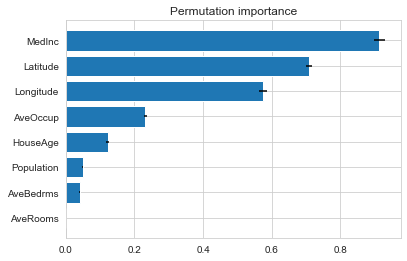

In [70]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(pi_result, features_name):
    """ bar plot the feature importance """
    plt.figure(figsize=(30, 30))
    fig, ax = plt.subplots()

    indices = pi_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             pi_result['importances_mean'][indices],
             xerr=pi_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    tmp = np.array(features_name)
    ax.set_yticklabels(tmp[indices])
    ax.set_title("Permutation importance")

ppl_ensemble.fit(X_test,y_test)
pi_result = permutation_importance(ppl_ensemble, X_test, y_test)
plot_feature_importances(pi_result, X_test.columns)

## Save the best model

In [71]:
# Save the best model in PMML format
sklearn2pmml(best_pipeline, "../../../data/house-price-ensemble-regressor.pmml")